In [94]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from modules.simulation import UniverseSimulator
import configparser

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
import configparser
default_config_capish = configparser.ConfigParser()
default_config_capish.read('../config/capish_flagship.ini')

['../config/capish_flagship.ini']

In [96]:
default_config_capish['parameters']['sigma_Mwl_gal'] = '0.0'
default_config_capish['parameters']['sigma_Mwl_int'] = '0.1'
default_config_capish['cluster_catalogue']['theory_sigma_Mwl_gal'] = 'False'
default_config_capish['cluster_catalogue']['add_correction_to_mean_log10Mwl'] = 'True'
default_config_capish['cluster_catalogue']['recompute_theory_sigma_Mwl_gal'] = 'False'
default_config_capish['cluster_catalogue']['gaussian_lensing_variable'] = 'log10Mwl'
default_config_capish['summary_statistics']['Gamma'] = '0.7'
default_config_capish['summary_statistics']['use_stacked_sigma_Mwl_gal'] = 'True'
sim = UniverseSimulator(default_config_path = None , default_config = default_config_capish, 
                        variable_params_names = ['Omega_m','sigma8'])

WL scatter is not already used on individual WL masses
=> You are allowed to apply WL scatter model on stacked WL masses!
Loading /pbs/throng/lsst/users/cpayerne/capish/modules/cluster/model_log10mWL_Rmin1.0_Rmax5.0_ngal25.0_ShapeNoise0.3_M200matter_cMDuffy08.pkl


In [97]:
N, log10M = sim.run_simulation([0.319, 0.81])

[0.00399262 0.0047956  0.00443379 0.00493028 0.00764064]
[0.00439916 0.00562599 0.00528323 0.00660772 0.01131795]
[0.00540327 0.00708132 0.00735548 0.01002274 0.02133074]
[0.00883108 0.01283121 0.01394639 0.02188966 0.05548941]


In [98]:
N.shape

(5, 4)

Text(0, 0.5, 'log10M_capish')

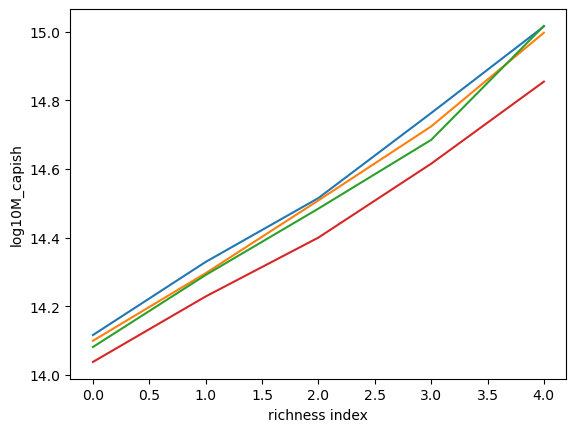

In [99]:
plt.plot(log10M)
plt.xlabel('richness index')
plt.ylabel('log10M_capish')

In [ ]:
sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/')
from modules.cluster import cluster_catalogue

In [ ]:
cl = cluster_catalogue.ClusterCatalogue(default_config_capish)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Define colormap based on log10m range
norm = mcolors.Normalize(vmin=np.min(cl.log10m_grid[cl.log10m_grid > 13.5]), vmax=np.max(cl.log10m_grid[cl.log10m_grid > 13.5]))
cmap = cm.hsv  # you can change to 'plasma', 'cividis', etc.
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(figsize=(5,4))

# Loop through each mass
for i, log10m in enumerate(cl.log10m_grid):
    if log10m < 13.5: continue
    color = sm.to_rgba(log10m)
    plt.plot(
        cl.z_grid,
        cl.sigma_log10M[i, :], '--',
        color=color,
        lw=1
    )

    plt.plot(
        cl.z_grid,
        np.sqrt(cl.sigma_log10M[i, :]**2 + 0.05**2),
        color=color,
        lw=1, ls='-', 
    )
plt.plot(
        cl.z_grid,
        np.sqrt(0.05**2) * np.ones(len(cl.z_grid)),
        color='k',
        lw=2, ls=':',  label = r'$\sigma_{\rm WLint}$'
    )
plt.plot([], [], '--k', label = r'$\sigma_{\rm WLgal}$')
plt.plot([], [], '-k', label = r'$\sigma_{\rm WL}$')
# Add colorbar and labels
cbar = plt.colorbar(sm)
cbar.set_label(r'$\log_{10}(M / M_\odot)$', fontsize=14)
plt.legend(ncols=1, frameon=True, framealpha=1, loc='upper left', fontsize=10)
#plt.yscale('log')
plt.ylim(-0., 0.6)
plt.xlabel('Redshift', fontsize=14)
plt.ylabel(r'$\sigma(\log_{10}M)$', fontsize=16)
#plt.hlines(0.2, 0.2, 1.2, color='k', ls='--')
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.xlim(0.2, 1.2)
plt.savefig(f'sigmaWL.png', dpi = 300, bbox_inches='tight',)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Define colormap based on log10m range
norm = mcolors.Normalize(vmin=np.min(cl.z_grid), vmax=np.max(cl.z_grid))
cmap = cm.rainbow # you can change to 'plasma', 'cividis', etc.
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(figsize=(5,3))

# Loop through each mass
for i, z in enumerate(cl.z_grid):

    color = sm.to_rgba(z)
    plt.plot(
        cl.log10m_grid,
        cl.sigma_log10M[:,i], '-',
        color=color,
        lw=1
    )


  


# Add colorbar and labels
cbar = plt.colorbar(sm)
cbar.set_label(r'redshift', fontsize=14)
#plt.legend(ncols=1, frameon=True, framealpha=1, loc='upper left', fontsize=14)
#plt.yscale('log')
plt.ylim(-0., 0.6)
plt.xlim(13.5, 16)
plt.xlabel(r'$\log_{10}(M / M_\odot)$', fontsize=14)
plt.ylabel(r'$\sigma_{\rm WL}$', fontsize=16)
#plt.hlines(0.2, 0.2, 1.2, color='k', ls='--')
plt.grid(True, alpha=0.4)
plt.tight_layout()
#plt.xlim(0.2, 1.2)
plt.savefig(f'sigmaWL.png', dpi = 300, bbox_inches='tight',)